# Tweet-Clustering: Tf-IDF FastText Embedding

In [1]:
import numpy as np
import pandas as pd
import imp
import lexrank
from matplotlib import pyplot as plt
from data_providers import DummyDataProvider, CachedSmallDataProvider
from clustering import DummyClustering, KMeansClustering, KMeansClusteringNew
from preprocessors import DummyPreprocessor, Cleaner
from vectorizers import DummyVectorizer, FastTextMeanVectorizer, FastTextTfIdfMeanVectorizer, TfIdfVectorizer, ElmoVectorizer
from sentiment import VaderSentimentAnalyser
from labeler import LexRankSummarizer
import utils
import random

In [2]:
dataProvider1 = CachedSmallDataProvider("iphone")
tweets1 = dataProvider1.load_data()
tweets1[:1]

['Create awesome custom faces for your #AppleWatch. Download AWC Faces #iphone #app https://t.co/ctiK1X9Kda']

In [3]:
# 1. DATA
dataProvider2 = CachedSmallDataProvider("alexa")
tweets2 = dataProvider2.load_data()
print("number ", len(tweets2))
tweets2[:1]

number  5469


['He’s so #beautiful love him! 🌸📚💕 #ariemanuel #mymollydoll #blog Thanks for following everyone! We are currently 8.3k share a following with @sassique where I’m a member and Ranked 37,818 in the #US on #Alexa // #blogger #blog #website @WMEBooks #thoughts 📖 https://t.co/m2RitarZYP']

In [4]:
# DATA
dataProvider3 = CachedSmallDataProvider("brexit")
tweets3 = dataProvider3.load_data()
print("number ", len(tweets3))
tweets3[:1]

number  71827


["Hey @tracey_crouch @TomTugendhat  Is this one of those #Brexit divedends for Kent we've been hearing so much about? https://t.co/hT85eKXHZz"]

In [5]:
# DATA
dataProvider4 = CachedSmallDataProvider("baseball")
tweets4 = dataProvider4.load_data()
print("number ", len(tweets4))
tweets4[:1]

number  3739


['Hey @MLB how about some justice for @PeteRose_14 he did nothing compared to the @astros #baseball']

In [6]:
# DATA
dataProvider5 = CachedSmallDataProvider("iran")
tweets5 = dataProvider5.load_data()
print("number ", len(tweets5))
tweets5[:1]

number  35167


['Can the #US bomb #Iran? Defense chief #Esper says no, then changes mind  https://t.co/avZn4sg8tt https://t.co/zLvik6fv87']

In [7]:
# DATA
dataProvider6 = CachedSmallDataProvider("trump")
tweets6 = dataProvider6.load_data()
print("number ", len(tweets6))
tweets6[:1]
# Result 22 clusters (sa) - highly polarized

number  34991


['@Farcethemusic And I say... 🎶 “let’s Build A Wall around the White House &amp; then let’s lock him up”https://t.co/UAYJTZQCff #CountryMusic #Country #Nashville #POTUS #Trump #BananaRepublic #2020Election #AbuseOfPower #Americana #25thAmendmentNow #AltFolk #NewMusicAlert #NewMusic #Ukrainegate']

In [8]:
#merge tweets
tweets = tweets1

#random.shuffle(tweets)

In [9]:
# needs reduction
tweets = tweets[:1000]

In [10]:
cleaner = Cleaner()
# does various clean up-jobs
vocabDicFreq, vocabDic,clean_tweets = cleaner.clean_tweets(tweets, 2 )

In [11]:
# corpus information before threshold removal
# Corpus Information cleaned tweets
sortedDicFreq = {k: v for k, v in sorted(vocabDicFreq.items(), key=lambda item: item[1], reverse=True)}
listeWords = list(sortedDicFreq.keys())
listeValues = list(sortedDicFreq.values())
for element in listeWords[:10]:
    print(element, " : ", sortedDicFreq[element])
pd.Series(listeValues).describe().T

iphone  :  1192
  :  1131
apple  :  432
android  :  144
new  :  115
ios  :  110
ipad  :  105
phone  :  91
samsung  :  86
tech  :  80


count    1172.000000
mean       10.361775
std        50.514016
min         3.000000
25%         3.000000
50%         4.000000
75%         8.000000
max      1192.000000
dtype: float64

In [12]:
# test cleaning and vocab
print(clean_tweets[:1])

['create awesome faces applewatch download faces iphone app']


# TF_IDF CLUSTERING ON FULL TWEET

In [13]:
# preVectorize
preVectorizer = TfIdfVectorizer()
docSparseTfIdf = preVectorizer.vectorize(vocabDic, clean_tweets)
# test tfidf vectors
print("Tf-IDF Sparse Vectors shape")
print("laenge pro vector = vocabSize ", len(docSparseTfIdf[0]))
print("anzahl der dokumente ", len(docSparseTfIdf))
#print(docSparseTfIdf[0])
#print(vocabDic)
# better


Tf-IDF Sparse Vectors shape
laenge pro vector = vocabSize  1172
anzahl der dokumente  1000


In [14]:
vectorizer = FastTextTfIdfMeanVectorizer()

In [17]:
# vectorize - much faster laufzeit for clustering
vecs = vectorizer.vectorize(docSparseTfIdf,vocabDic)
print ("word2vec vectors shape")
print(vecs.shape)
print()

word2vec vectors shape
(1000, 300)



# Find optimal number for k-means with three coefficients +1 optimal
1. silhouette_score - 
a: The mean distance between a sample and all other points in the same class.
b: The mean distance between a sample and all other points in the next nearest cluster.
formula: s = (b-a) / max (a,b)
Problem: prone to 1 point clusters....

2. calinski_harabasz_score - verteilung der cluster und innere Dichte - looks at ALL
Ratio of between cluster dispersion mean and the within cluster dispersion -> higher better 

3. davies_bouldin_score: looks only at nearest cluster
The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Formula: Rij = (si + sj)  / dij with_ s(imiliarity) within cluster, ie. average distance of points to centroid, and d(istance) between cluster-centroids. -> DB = 1/k Sum max Rij (with i != j)


In [18]:
# setting for kmeans clustering n-cluster min and max
min = 2
max = 66

In [19]:
# 2.A. Determina optimal number of cluster - other method - with hashtags - only 2/3s due to duplicates can be checked
# DIFFERENT SETTINGS FOR optimal number of clusters i.e. init="k-means++", max_iter etc. pp.
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
clusterer = KMeansClusteringNew()
SA = {}
CH = {}
DB = {}
for index in range(min, max):
    cluster_labels = clusterer.cluster(vecs, index)
    SA[index] = silhouette_score(vecs, cluster_labels)
    CH[index] = calinski_harabasz_score(vecs, cluster_labels)
    DB[index] = davies_bouldin_score(vecs, cluster_labels)

# find minimum and Maximum
sortedSA = {k: v for k, v in sorted(SA.items(), key=lambda item: item[1], reverse=True)}
bestSAIndex = next(iter(sortedSA))
print(" SA best ", bestSAIndex, " : ", SA[bestSAIndex] )
sortedSA = {k: v for k, v in sorted(SA.items(), key=lambda item: item[1], reverse=False)}
worstSAIndex = next(iter(sortedSA))
print(" SA worst ", worstSAIndex, " : ", SA[worstSAIndex] )
#print("SA", pd.Series(list(SA.values())).describe().T)
# ++++++++++++++++++++++++++++++++++++++
sortedCH = {k: v for k, v in sorted(CH.items(), key=lambda item: item[1], reverse=True)}
bestCHIndex = next(iter(sortedCH))
print(" CH best ", bestCHIndex, " : ", CH[bestCHIndex] )
sortedCH = {k: v for k, v in sorted(CH.items(), key=lambda item: item[1], reverse=False)}
worstCHIndex = next(iter(sortedCH))
print(" CH worst ", worstCHIndex, " : ", CH[worstCHIndex] )
#print("CH", pd.Series(list(CH.values())).describe().T)
# +++++++++++++++++++++++++++++++++++++++++
sortedDB = {k: v for k, v in sorted(DB.items(), key=lambda item: item[1], reverse=False)}
bestDBIndex = next(iter(sortedDB))
print(" DB best ", bestDBIndex, " : ", DB[bestDBIndex] )
sortedDB = {k: v for k, v in sorted(DB.items(), key=lambda item: item[1], reverse=True)}
worstDBIndex = next(iter(sortedDB))
print(" DB worst ", worstDBIndex, " : ", DB[worstDBIndex] )
#print("DB", pd.Series(list(DB.values())).describe().T)

# ++++++++++++++ create mixed ranking
Ranking = {}
for index in range(min, max):
    Ranking[index] = SA[index]/SA[bestSAIndex] + CH[index]/CH[bestCHIndex] - DB[index]/DB[worstDBIndex]
    #print(Ranking[index])
sortedRanking = {k: v for k, v in sorted(Ranking.items(), key=lambda item: item[1], reverse=True)}
count = 10
for key, value in sortedRanking.items():
    count -=1
    print(key, " ", value, " Silhouette ", SA[key])
    if count == 0:
        break

 SA best  2  :  0.07061359640680544
 SA worst  4  :  -0.10579965223942048
 CH best  2  :  62.534097969331214
 CH worst  63  :  13.352100676459983
 DB best  62  :  1.9765563672652209
 DB worst  3  :  3.7146293030955646
2   1.0171753530269747  Silhouette  0.07061359640680544
62   0.2665974765211411  Silhouette  0.039620840224885864
65   0.26328399679606185  Silhouette  0.04085264575018536
61   0.2220265709181033  Silhouette  0.03893838720886355
59   0.1711065776107905  Silhouette  0.036852420634511246
64   0.15712078874593582  Silhouette  0.034552869075272434
63   0.15489066687510744  Silhouette  0.03607368920951102
32   0.08570777540493868  Silhouette  0.027582576058273453
60   0.07984803515942351  Silhouette  0.02987019896828504
56   0.07455505032722443  Silhouette  0.030151909383987322


In [20]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
bandwidth = estimate_bandwidth(vecs, quantile=0.2, n_samples=1000)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(vecs)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 1


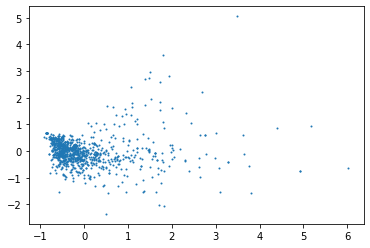

In [21]:
# graph
print()
utils.scatter2d(vecs)


# distribution of clusters

In [22]:
cluster_optimal_number = 60

In [23]:
# cluster assignement numbers
cluster_assignments = clusterer.cluster(vecs, cluster_optimal_number)
print( "cluster assignments: ")
clusterCount = pd.Series(cluster_assignments).value_counts()
print(clusterCount.describe().T)
print(clusterCount)



cluster assignments: 
count    60.000000
mean     16.666667
std      16.244599
min       1.000000
25%       4.000000
50%      13.000000
75%      21.000000
max      76.000000
dtype: float64
8     76
6     63
23    60
35    44
38    41
2     38
17    36
37    35
29    34
5     32
53    31
57    31
7     29
20    22
9     21
31    21
44    21
36    21
15    19
46    18
16    18
1     17
12    16
3     14
24    14
59    14
56    14
49    14
28    13
4     13
13    13
14    13
32    11
22    11
39    10
55     9
40     9
48     8
33     7
58     7
43     6
30     6
27     5
25     4
42     4
34     4
52     4
0      4
47     4
10     3
50     3
21     3
41     3
54     2
45     2
11     1
26     1
51     1
19     1
18     1
dtype: int64


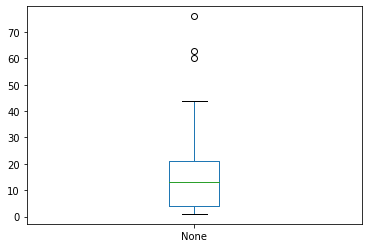

In [24]:
clusterCount.plot.box()

For n_clusters = 60 The average silhouette_score is : 0.10148639448769294


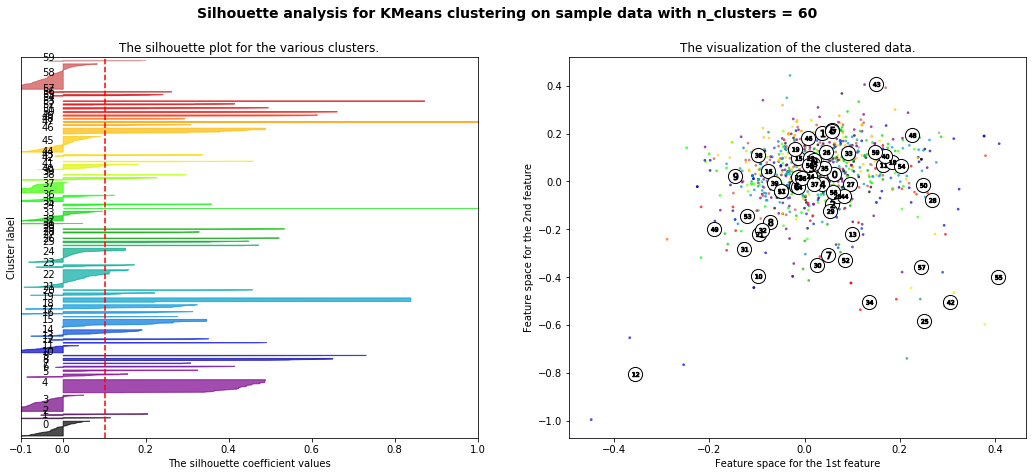

In [25]:
# analyser TFIDF
min = cluster_optimal_number
max = cluster_optimal_number + 1
clusterer.silhouette_analyser(vecs, min, max)




In [26]:
def sentiment(df):
    sentiment_analyser = VaderSentimentAnalyser()
    sentiments = sentiment_analyser.get_sentiment(clean_tweets)
    df['sentiment'] = sentiments
    df.sort_values(by=['cluster'], inplace=True, ascending=True)
    print(df.groupby(['cluster'])['sentiment'].mean())
    # give min, max and mean "tweets"
    print(df.nsmallest(20, 'sentiment'))
    print(df.nlargest(20, 'sentiment'))
    
    #sortedDB = {k: v for k, v in sorted(DB.items(), key=lambda item: item[1], reverse=False)}


In [27]:
def topWords(df, clusterNum):
#find 10 most frequent words for each cluster
# vars
    clusterNumber = clusterNum
    clusterStr = ["" for i in range(clusterNumber)]
    topTex = [[] for i in range(clusterNumber)]
    clusterSent =[0 for i in range(clusterNumber)]
    for index in range(len(clean_tweets)):
        cluster = df.at[index, 'cluster']
        string = clusterStr[cluster]
        string += str(df.at[index, 'tweets'])
        string += " "
        clusterStr[cluster] = string
    # sort 
    # clean and count words in 
    for index in range(clusterNumber):
        liste1 = ["", clusterStr[index]]
        vocabDicFreq2, vocabDic2, clean_tweets2 = cleaner.clean_tweets(liste1, 0)
        sortedDicFreq = {k: v for k, v in sorted(vocabDicFreq2.items(), key=lambda item: item[1], reverse=True)}
        liste = list(sortedDicFreq.keys())
        topTex[index] = liste[:10]
    for index in range(clusterNumber):
        print("Cluster ", index, " top 10: ", topTex[index])
        


In [28]:
dictClusterTweets = {'cluster':cluster_assignments, 'tweets':clean_tweets}
df = pd.DataFrame(dictClusterTweets)
df['Counts'] = df.groupby(['cluster']).transform('count')
pd.options.display.max_colwidth = 4000
pd.set_option('display.max_rows', df.shape[0]+1)

topWords(df, cluster_optimal_number)

Cluster  0  top 10:  ['texas', 'galveston', 'seascape', 'wallart', 'interiordecor', 'tapestry', 'pillow', 'iphone', 'case', 'cup']
Cluster  1  top 10:  ['iphone', 'us', 'dm', 'check', 'free', 'iphones', '8plus', 'jaiiryda', 'inquiries', 'web']
Cluster  2  top 10:  ['iphone', 'app', 'apps', 'ipad', 'new', 'android', 'apple', 'free', 'january', '2020']
Cluster  3  top 10:  ['iphone', 'art', 'dynamic', 'portrait', 'user', 'new', '', 'giant', 'small', 'soft']
Cluster  4  top 10:  ['iphone', 'wireless', 'charger', 'usb', 'bluetooth', 'cable', 'samsung', 'lightning', 'earbuds', 'android']
Cluster  5  top 10:  ['iphone', 'apple', 'iphone11', 'iphonexsmax', 'iphonex', 'iphone11promax', 'iphonexs', 'iphonexr', 'iphone11pro', 'ios1331']
Cluster  6  top 10:  ['iphone', 'apple', 'get', 'want', 'phone', 'ipad', 'else', 'people', 'unlock', 'even']
Cluster  7  top 10:  ['iphone', '', 'listen', 'apple', 'hit', 'android', 'trap', 'ringtone', 'trapbeat', 'trapmusic']
Cluster  8  top 10:  ['iphone', 'tec

In [29]:
sentiment(df)

cluster
0     0.519350
1     0.726612
2     0.681374
3     0.660014
4     0.488396
5     0.535492
6     0.563693
7     0.496612
8     0.659334
9     0.603295
10    0.604150
11    0.500000
12    0.670000
13    0.633173
14    0.754758
15    0.553084
16    0.599214
17    0.582050
18    0.500000
19    0.500000
20    0.646241
21    0.420550
22    0.630414
23    0.668120
24    0.537100
25    0.682613
26    0.340900
27    0.852230
28    0.500000
29    0.565866
30    0.542550
31    0.717905
32    0.406700
33    0.500000
34    0.500000
35    0.622942
36    0.612710
37    0.572139
38    0.685283
39    0.524695
40    0.599578
41    0.746950
42    0.750063
43    0.550308
44    0.598631
45    0.500000
46    0.684986
47    0.720200
48    0.521250
49    0.500000
50    0.835917
51    0.261650
52    0.585100
53    0.610808
54    0.659225
55    0.397078
56    0.572389
57    0.582960
58    0.572036
59    0.679886
Name: sentiment, dtype: float64
     cluster  \
400       59   
237        6   
952       20

In [30]:
df["sentiment"].describe().T

count    1000.000000
mean        0.607542
std         0.168870
min         0.058300
25%         0.500000
50%         0.500000
75%         0.746950
max         0.980350
Name: sentiment, dtype: float64